This notebook demonstrates the working principle of our framework.

We would do the following things:

- Loading a progress learner model that has been trained on real human demonstrations.

- Using the learned model, demonstrate a simple demonstration on 2-D visualizer. This demo will demonstrate the result using a simple searching (*exploration only mode*) to find a good demonstration, and finish when the progress threshold attains a certain value.

First we load several needed libraries:

In [39]:
import os
import sys
import collections

# Import third party libraries
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline


# Import local libraries
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
a = os.path.join(module_path, "strands_qsr_lib\qsr_lib\src3")

sys.path.append(a)

import plotting
from rl import action_learner, action_learner_search, value_estimator, discrete_action_learner_search as dal
import progress_learner
import config
import project
# Need to add this import to load class
from project import Project
from rl import block_movement_env
import utils
from importlib import reload

A project used to store data for training, and other meta-data for each action (e.g. name) *../slidearound_project.proj*

The model that has been learned for action **Slide Around** is stored at *../progress_SlideAround.mod*.

In the following code, we create a default setup of config. Some important variables in config file is:

- **progress_threshold**: This is a threshold of our progress function that when searching for completion of action, we can stop searching (stop condition). 

- **keep_branching**: Number of explorations kept in each exploration time step

- **branching**: Number of states would be explored from the current exploration

In [42]:
p = project.Project.load(os.path.join('..', utils.MODEL_PATH, 'slidearound_project.proj'))
c = config.Config()
c.progress_threshold=0.92
c.keep_branching = 24
c.branching = 24

The following code load tensorflow model that has been trained for *Slide Around*, and prints out the parameters in the model. 

In [41]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)

sess =  tf.Session()

with tf.variable_scope("search") as scope:
    policy_estimator = action_learner_search.PolicyEstimator(c)

sess.run(tf.global_variables_initializer())

with tf.variable_scope("model") as scope:
    print('-------- Load progress model ---------')
    progress_estimator = progress_learner.EventProgressEstimator(is_training=False, name = p.name, config = c)  

# Print out all variables that would be restored
for variable in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model'):
    print (variable.name)

saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model'))
saver.restore(sess, os.path.join('..', utils.MODEL_PATH, 'progress_SlideAround.mod'))

-------- Load progress model ---------
self.inputs.shape = (?, 20, 200)  after linear layer
output.shape = (30, 200) after LSTM
self.output.shape = (30,) after linear
self._targets.shape = (?,) 
model/SlideAround/linear/weight:0
model/SlideAround/linear/bias:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0
model/SlideAround/output_linear/weight:0
model/SlideAround/output_linear/bias:0
INFO:tensorflow:Restoring parameters from ..\learned_models\progress_SlideAround.mod


In [30]:
action_ln = dal.Discrete_ActionLearner_Search(c, p, progress_estimator, session = sess)

The *exploration* is as followings:

1. Start with a randomized setup

2. This setup corresponds to 1 exploration with no history.

3. For each exploration, choose one of 24 or *branching* positions to move to.

4. Keep 24 or *keep_branching* best explorations (history) we have seen so far.

5. Back to 3

6. STOP if the best progress value doesn't increase after one step OR when the best exploration excess threshold

In [31]:
explorations = action_ln.learn_one_setup(verbose = True)

action_level = 0
exploration_index = 0
=== Best explorations ===
[(0, 0.738186240196228), (0, 0.7063241600990295), (0, 0.49129870533943176), (0, 0.42514657974243164), (0, 0.3670833706855774), (0, 0.3157680928707123), (0, 0.27931368350982666), (0, 0.23455612361431122), (0, 0.18849259614944458), (0, 0.18043340742588043), (0, 0.025169363245368004), (0, 0.016109971329569817), (0, 0.013015319593250751), (0, 0.01083966065198183), (0, 0.007172177545726299), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0)]
action_level = 1
exploration_index = 0
exploration_index = 1
exploration_index = 2
exploration_index = 3
exploration_index = 4
exploration_index = 5
exploration_index = 6
exploration_index = 7
exploration_index = 8
exploration_index = 9
exploration_index = 10
exploration_index = 11
exploration_index = 12
exploration_index = 13
exploration_index = 14
exploration_index = 15
exploration_index = 16
exploration_index = 17
exploration_index = 18
exploration

We can see that the best progress value doesn't exceed our threshold of 0.92. The resulted demonstration is sometimes very bad.

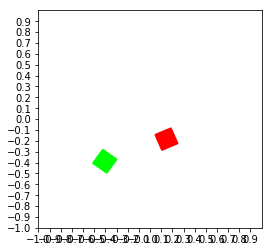

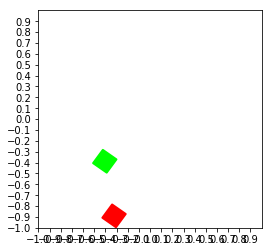

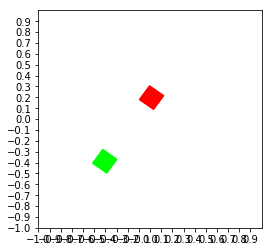

In [32]:
explorations[0].replay(verbose = False)

More demonstrations of this method could be found at **experiments\human_evaluation_2d\SlideAroundDiscrete**